In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

contradictory_my_dear_watson_path = kagglehub.competition_download('contradictory-my-dear-watson')

print('Data source import complete.')


100%|██████████| 1.78M/1.78M [00:01<00:00, 1.69MB/s]

Extracting files...
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
train_path = contradictory_my_dear_watson_path + '/train.csv'
test_path = contradictory_my_dear_watson_path + '/test.csv'
sample_submission_path = contradictory_my_dear_watson_path + '/sample_submission.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


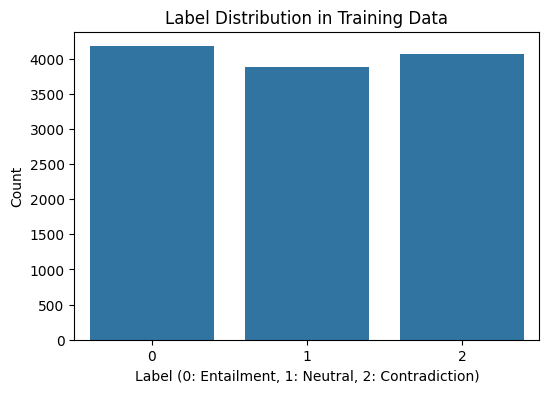

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title('Label Distribution in Training Data')
plt.xlabel('Label (0: Entailment, 1: Neutral, 2: Contradiction)')
plt.ylabel('Count')
plt.show()


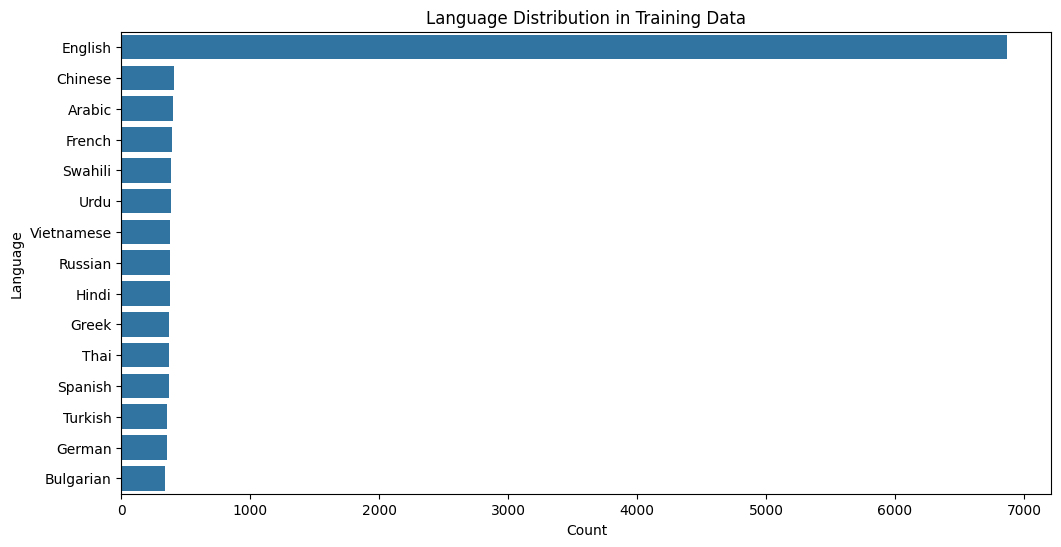

In [ ]:
# Plot language distribution
plt.figure(figsize=(12,6))
sns.countplot(y='language', data=train_df, order=train_df['language'].value_counts().index)
plt.title('Language Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()


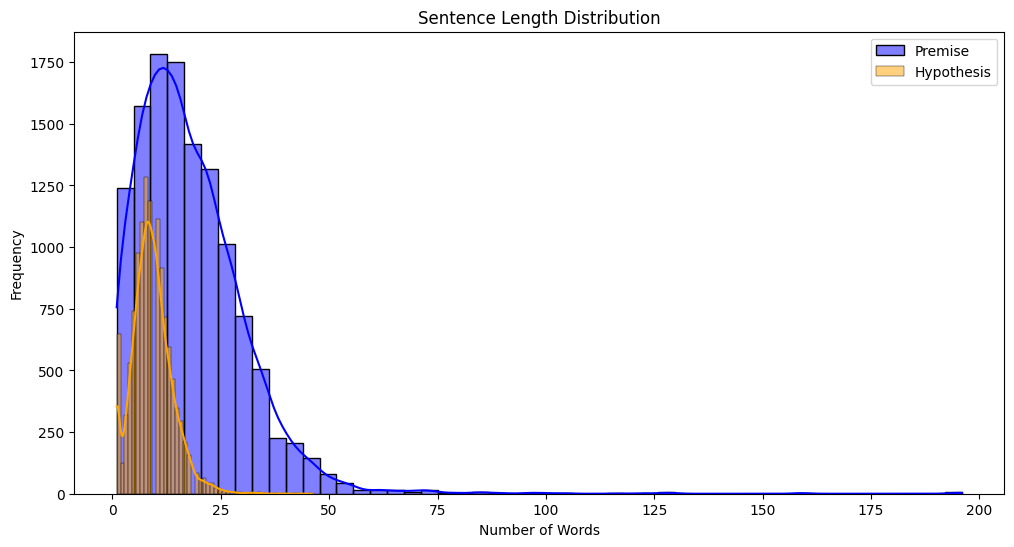

In [ ]:
# Calculate sentence lengths
train_df['premise_length'] = train_df['premise'].apply(lambda x: len(x.split()))
train_df['hypothesis_length'] = train_df['hypothesis'].apply(lambda x: len(x.split()))

# Plot premise length distribution
plt.figure(figsize=(12,6))
sns.histplot(train_df['premise_length'], bins=50, kde=True, color='blue', label='Premise')
sns.histplot(train_df['hypothesis_length'], bins=50, kde=True, color='orange', label='Hypothesis')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()


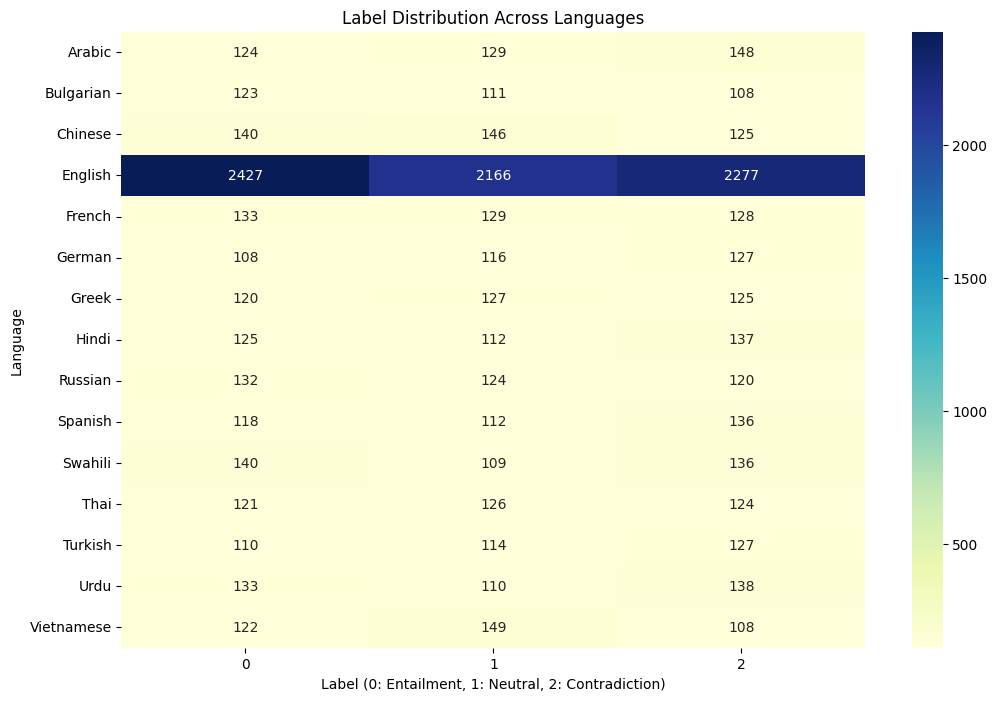

In [ ]:
language_label_counts = train_df.groupby(['language', 'label']).size().unstack(fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(language_label_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Label Distribution Across Languages')
plt.xlabel('Label (0: Entailment, 1: Neutral, 2: Contradiction)')
plt.ylabel('Language')
plt.show()


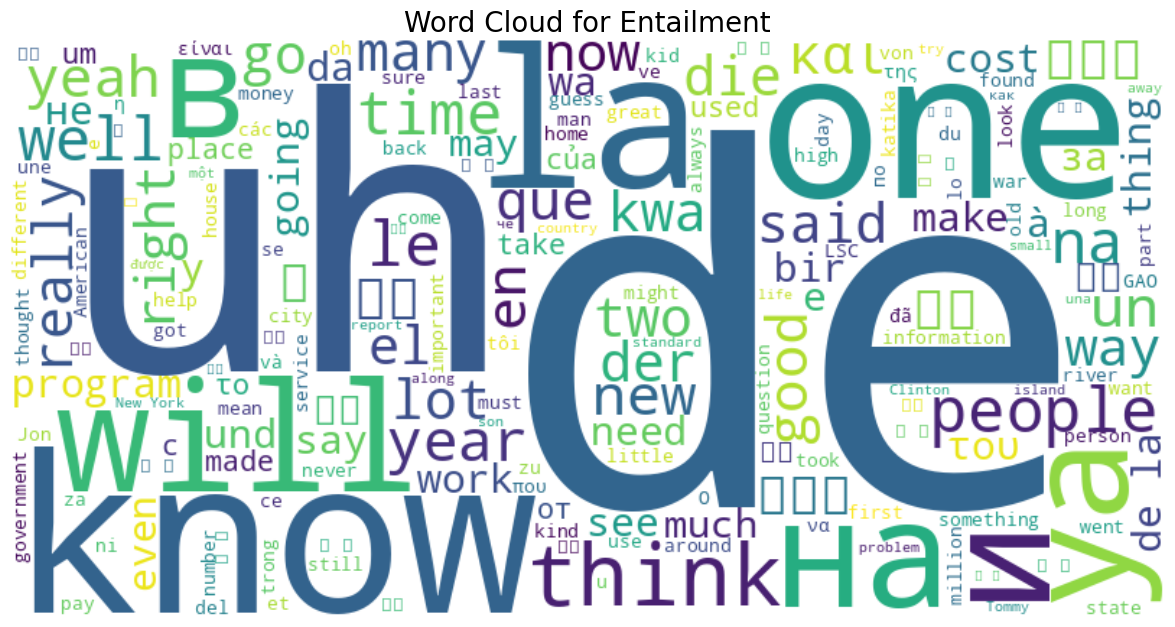

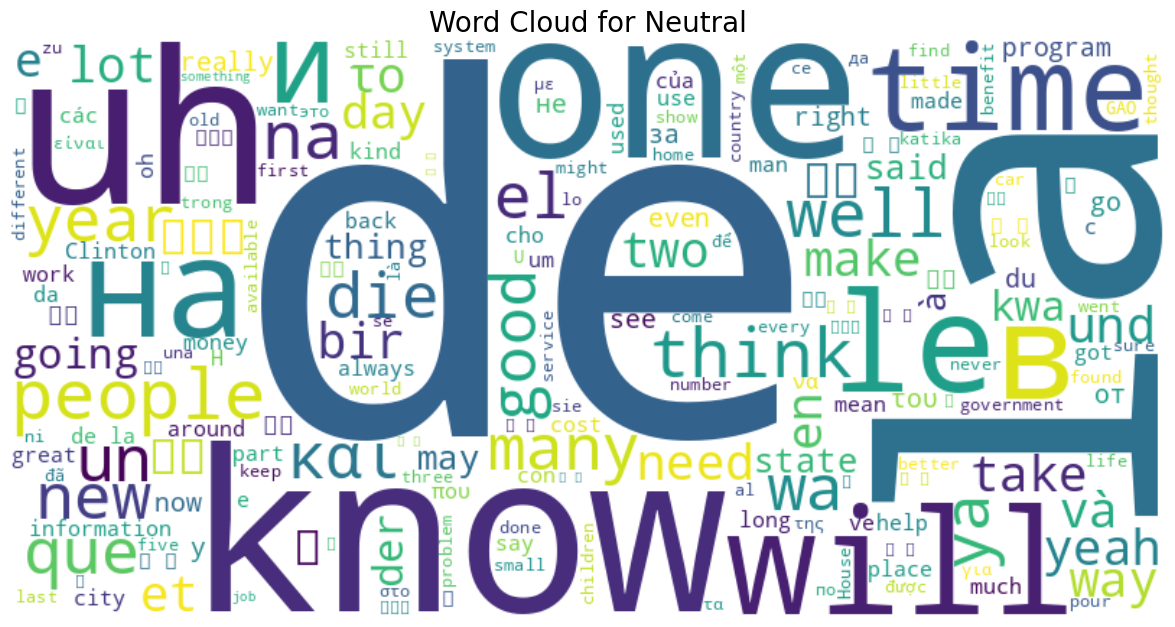

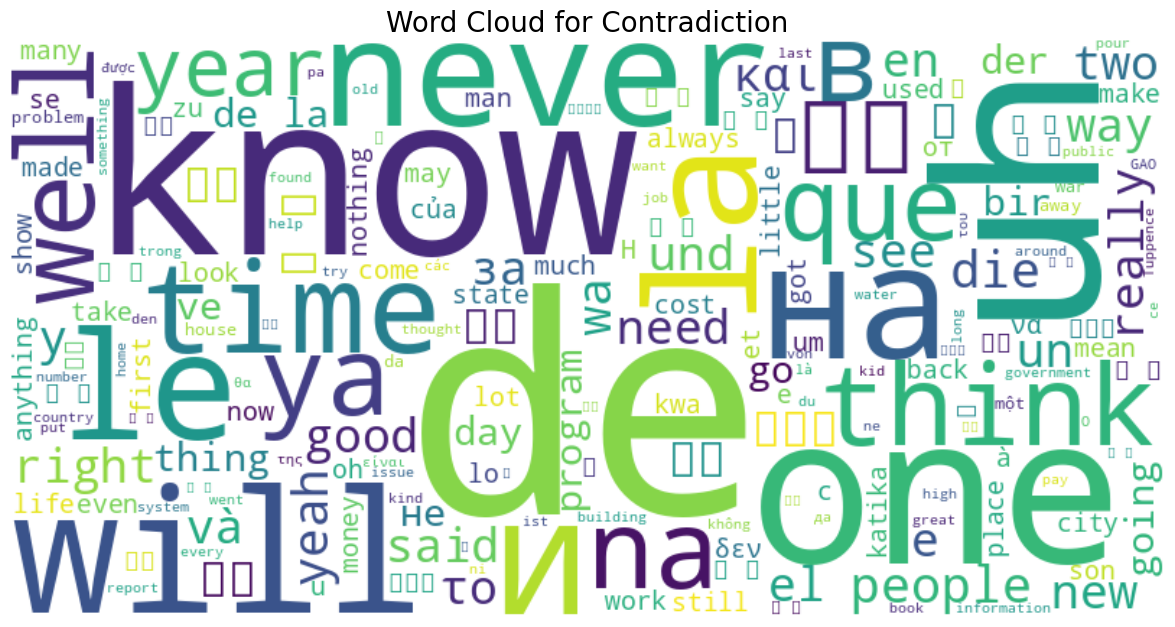

In [ ]:
from collections import Counter
from wordcloud import WordCloud

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

labels = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

for label in labels:
    subset = train_df[train_df['label'] == label]
    text = subset['premise'].tolist() + subset['hypothesis'].tolist()
    generate_wordcloud(text, f'Word Cloud for {labels[label]}')


In [ ]:
# Check for missing values
print("Missing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())


Missing values in training data:
 id                   0
premise              0
hypothesis           0
lang_abv             0
language             0
label                0
premise_length       0
hypothesis_length    0
dtype: int64

Missing values in test data:
 id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


In [ ]:
# Drop rows with missing premise or hypothesis
train_df = train_df.dropna(subset=['premise', 'hypothesis']).reset_index(drop=True)
test_df = test_df.dropna(subset=['premise', 'hypothesis']).reset_index(drop=True)


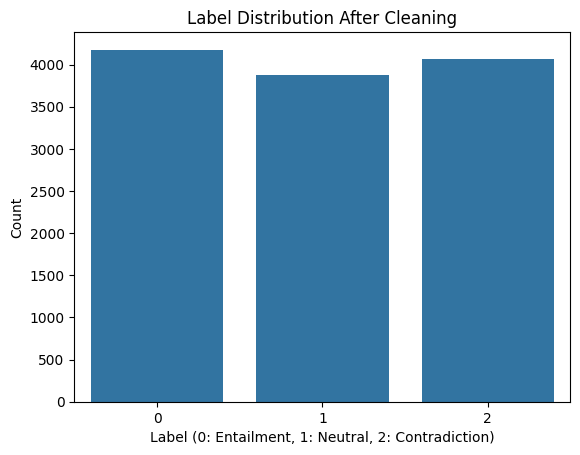

In [ ]:
# Ensure labels are integers
train_df['label'] = train_df['label'].astype(int)

# Check label distribution after cleaning
sns.countplot(x='label', data=train_df)
plt.title('Label Distribution After Cleaning')
plt.xlabel('Label (0: Entailment, 1: Neutral, 2: Contradiction)')
plt.ylabel('Count')
plt.show()


In [ ]:
# Combine premise and hypothesis for tokenization
train_texts = train_df[['premise', 'hypothesis']].apply(lambda x: ' '.join(x), axis=1).tolist()
train_labels = train_df['label'].tolist()

# Split the training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")


Training samples: 10908
Validation samples: 1212


In [ ]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_df[['premise', 'hypothesis']].apply(lambda x: ' '.join(x), axis=1).tolist())


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
import torch

class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = NLIDataset(train_encodings, train_labels)
val_dataset = NLIDataset(val_encodings, val_labels)
test_dataset = NLIDataset(test_encodings)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    return {
        'accuracy': report['accuracy'],
        'precision': np.mean([report[str(i)]['precision'] for i in range(3)]),
        'recall': np.mean([report[str(i)]['recall'] for i in range(3)]),
        'f1': np.mean([report[str(i)]['f1-score'] for i in range(3)])
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    fp16=True,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.107400,1.099827,0.344884,0.114961,0.333333,0.170961
2,1.104900,1.098812,0.344884,0.114961,0.333333,0.170961
3,1.101100,1.098136,0.344884,0.114961,0.333333,0.170961


TrainOutput(global_step=2046, training_loss=1.104293116609605, metrics={'train_runtime': 700.4883, 'train_samples_per_second': 46.716, 'train_steps_per_second': 2.921, 'total_flos': 2152530870432768.0, 'train_loss': 1.104293116609605, 'epoch': 3.0})

In [ ]:
# Evaluate on validation set
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 1.0998269319534302, 'eval_accuracy': 0.3448844884488449, 'eval_precision': 0.11496149614961497, 'eval_recall': 0.3333333333333333, 'eval_f1': 0.17096114519427405, 'eval_runtime': 3.6777, 'eval_samples_per_second': 329.553, 'eval_steps_per_second': 20.665, 'epoch': 3.0}


In [ ]:
# Make predictions on test data
test_preds = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_preds.predictions, axis=1)

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'prediction': test_pred_labels
})

# Ensure the submission format is correct
submission_df.head()

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
